# Gradient Descent numpy구현

Gradient Descent(경사하강법)은 함수의 기울기(경사)를 구하여, 기울기가 낮은 쪽으로 계속 이동시켜
극값에 이를 때까지 반복시키는 알고리즘이다.

## 손실함수 미분하기

$$
\mbox{예측함수 : } \hat y = w_1x + w_0\\
\mbox{손실함수 : } Loss(w_0,w_1) = \frac{1}{2m}\sum_{i=1}^{m}(\hat y - y)^2 = \frac{1}{2m}\sum_{i=1}^{m}(w_1x^{(i)}+w_0-y^{(i)})^2
$$



In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


In [0]:
# Dataset로드
movie_df = pd.DataFrame([
    [8759, 487],
    [10132,612],
    [12078,866],
    [16430,1030]],
    columns=["nums_want_to_see","nums_audience"])
movie_df.index = ["마션","킹스맨","캡틴아메리카","인터스텔라"]
movie_df

# 가중치 조합 만들기
W0s = np.linspace(-1000,1000,100)
W1s = np.linspace(-1,1,100)

points = np.stack(np.meshgrid(W0s,W1s),axis=-1) # 가중치 조합 만들기
points = points.reshape(-1,2)
points

# 손실 함수값 계산하기
def calculate_MSE(W0, W1):
    X = movie_df.nums_want_to_see # 독립 변수, 보고싶어요 수
    y_true = movie_df.nums_audience # 실제값

    y_pred = W1*X+W0 # 가중치 조합을 통한 예측값
    return ((y_true - y_pred)**2).mean() # MSE

losses = []
for W0, W1 in points:
    loss = calculate_MSE(W0, W1)
    losses.append(loss)
losses = np.array(losses)

# 가중치 별 손실값 확인하기
points_with_loss = np.concatenate([points,
                                   losses.reshape(-1,1)],
                                  axis=1)

loss_df = pd.DataFrame(points_with_loss,columns=['W0','W1','Loss'])

# 가중치 시각화
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

surf_value = loss_df.values.reshape(100,100,3)

업데이트를 하기위해 loss에 대해 w를 편미분 한다. <br>
MSE Loss function에 대해 w의 편미분의 수식은 아래와 같다.

$$
\frac{\partial Loss}{\partial w_0} = \frac{1}{m}\sum_{i=1}^{m}(w_1x^{(i)}+w_0 - y^{(i)})\\
\frac{\partial Loss}{\partial w_1} = \frac{1}{m}\sum_{i=1}^{m}(w_1x^{(i)}+w_0 - y^{(i)})x^{(i)}\\
$$

In [0]:
# W0에 대한 미분식
def calculate_wo_derivative(w0,w1):
    x = movie_df.nums_want_to_see # 독립 변수, 보고싶어요 수
    y_true = movie_df.nums_audience # 실제값
    return (w1*x + w0 - y_true).mean()

# W1에 대한 미분식
def calculate_w1_derivative(w0,w1):
    x = movie_df.nums_want_to_see # 독립 변수, 보고싶어요 수
    y_true = movie_df.nums_audience # 실제값
    return ((w1*x + w0 - y_true)*x).mean()

In [4]:
w0 = -500
w1 = -0.75
mse = calculate_MSE(w0,w1)
dw0 = calculate_wo_derivative(w0,w1)
dw1 = calculate_w1_derivative(w0,w1)

dw0,dw1

(-10136.0625, -126987182.9375)

Learning rate와 epoch을 적용하여 지속적인 gradient descent를 수행한다.

In [0]:
# 갱신된 weight와 mse 저장
w0_history = [w0]
w1_history = [w1]
mse_history = [mse]

alpha = 2e-10 # 학습률
epoch = 100 # 몇 번 학습할지 결정

for i in range(epoch):
    # 이전 가중치 가져오기
    old_w0 = w0_history[-1]
    old_w1 = w1_history[-1]
    
    # 미분값 갱신
    dw0 = calculate_wo_derivative(old_w0,old_w1)
    dw1 = calculate_w1_derivative(old_w0,old_w1)
    
    # 경사하강법을 통한 가중치 갱신
    new_w0 = old_w0 - alpha * dw0
    new_w1 = old_w1 - alpha * dw1
    new_mse = calculate_MSE(new_w0,new_w1)
    
    # 결과 저장
    w0_history.append(new_w0)
    w1_history.append(new_w1)
    mse_history.append(new_mse)

정상적으로 최적해를 찾아가는것을 볼 수 있다.

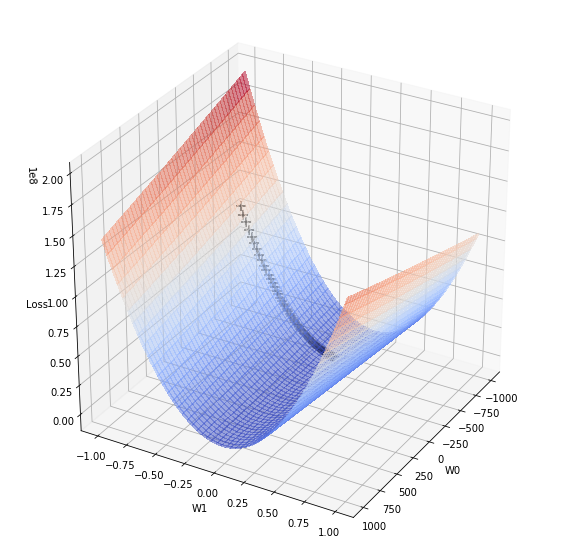

In [6]:
hist_df = pd.DataFrame({
    "W0":w0_history,
    "W1":w1_history,
    "Loss":mse_history
})

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.scatter(hist_df.W0, hist_df.W1, hist_df.Loss, 
           s=100, c='black', marker='+', zorder=-1)

surf = ax.plot_surface(X=surf_value[:,:,0],
                       Y=surf_value[:,:,1],
                       Z=surf_value[:,:,2],
                       cmap=cm.coolwarm,
                       linewidth=0,
                       antialiased=False,
                       alpha=0.5,)
ax.view_init(azim=30)
ax.set_xlabel('W0')
ax.set_ylabel('W1')
ax.set_zlabel('Loss')
plt.show()